# Question 1: Graph Classification

In this question we will be exploring graph classification on the dataset provided.

Overall, we will explore ways to implement graph level classification using GCNs; explore the given dataset and see how we can improve the GCN & training process overall to get a higher score on the dataset.

### HELPER FUNCTION & IMPORTS:

In [229]:
#Import Statements
import json
import torch
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [230]:
TRAIN_FILE_NAME = "q1_graph_classification_main_train.json"
EVAL_FILE_NAME = "q1_graph_classification_main_eval.json"

TRAIN_DATA_PATH = os.path.join("data",TRAIN_FILE_NAME)
EVAL_DATA_PATH = os.path.join("data",EVAL_FILE_NAME)

In [231]:
# Training function
def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False, **kwargs):
    model.train()
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()

        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True, **kwargs)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X, **kwargs)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


In [232]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 1.1 - Graph-Level Aggregation and Training

### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [233]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


### Q1.1.a - Graph-Level GCN

Implement three graph-level aggregation methods: sum, mean, and max. A GCN implemen-
tation is provided, and your task is to adapt it into a graph-level GCN by integrating different
aggregation functions.

In [234]:
# SOLUTION Q1.1.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(MyGraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = MyGCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = MyGCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Pass through GCN layers
        A_tilde = A + torch.eye(A.shape[0])  # Add self loops
        A_normalized = symmetric_normalize(A_tilde)
        H1 = self.gcn1(X, A_normalized)
        H2 = self.gcn2(H1, A_normalized)  # Output shape: (num_nodes, 1)

        # Graph aggregation
        if graph_aggregation_method == 'sum':
            graph_output = H2.sum(dim=0)
        elif graph_aggregation_method == 'max':
            graph_output = H2.max(dim=0).values
        else: # Default to mean
            graph_output = H2.mean(dim=0)

        graph_output = torch.sigmoid(graph_output.squeeze())

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_embeddings", None):
            return graph_output, H1, H2
        else:
            return graph_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

### Test your solution runs for all three aggregation methods.

Note - the input dataset features have dimensionionality 10.

### A full end-2-end Training script (make sure the below runs)

You only need to modify the aggregation parameter in this case.

In [235]:
# Preparing the Basics:
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)


In [236]:
# Training the model
random.shuffle(train_data)

# Initialize a list to store loss values for visualization
loss_values = []

# Training
num_epochs = 10

for epoch in range(num_epochs):
    # Train without returning embeddings for other epochs
    #note train_epoch accepts the additional param graph_aggregation_method and passes it (via kwargs) to the model.forward method.
    
    # ####################################################
    # MODIFY THE CODE BELOW 
    #  (note only aggregation param - and make sure to run all of them)
    # ####################################################    
    loss = train_epoch(model, train_data, optimizer, criterion, graph_aggregation_method="sum")


    # ####################################################
    # END OF MODIFICATION
    # ####################################################   
    print(f"Epoch {epoch+1}, Loss: {loss}")
    loss_values.append(loss)

Epoch 1, Loss: 0.37928408098267746
Epoch 2, Loss: 0.361760535770207
Epoch 3, Loss: 0.35641884184940753
Epoch 4, Loss: 0.35250494269271393
Epoch 5, Loss: 0.3495148472116632
Epoch 6, Loss: 0.3469290541776872
Epoch 7, Loss: 0.34469265644315095
Epoch 8, Loss: 0.342732264658094
Epoch 9, Loss: 0.34085469633062143
Epoch 10, Loss: 0.3390909767970725


In [237]:
# Evaluate the model on the test set
true_labels, predicted_labels, accuracy = test(model, eval_data)

# Debug: Print true and predicted labels
print("True labels:", true_labels)
print("Predicted labels:", predicted_labels)

# Calculate precision, recall (sensitivity), and F1-score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.5167
Precision: 0.7542
Recall: 0.5167
F1-score: 0.3693


### Q1.1.b. Graph-Level Training

Make modifications to the training script to:
1. Train the model and record the training loss and evaluation accuracy for each epoch.
2. Plot the test f1 for all three aggregation methods.

Use the provided functions:

• train model

• plot training and evaluation

In [238]:
# Helper function for plotting:

def plot_training_and_validation(training_losses, validation_losses, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch",title=None):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_losses) + 1)
    line1 = ax1.plot(epochs, training_losses, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"{x_label}")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_losses, 'b-', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    if not title:
        title = f'{graph1_label} and {graph2_label} Over Time\nAggregation: {aggregation}'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [239]:
# SOLUTION Q1.1.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def train_model(model, optimizer, criterion, train_dataset, validation_dataset, epochs, graph_aggregation_method, verbose):
    """Trains the model and records loss and validation accuracy
    Should return, train_losses, train_accuracy, validation_accuracy, train_f1_score, validation_f1_score
    """

    loss_arr = []
    train_acc_arr = []
    val_acc_arr = []
    train_f1_arr = []
    val_f1_arr = []

    for epoch in range(epochs):
        loss = train_epoch(model, train_dataset, optimizer, criterion, graph_aggregation_method=graph_aggregation_method)

        true_labels_train, predicted_labels_train, train_acc = test(model, train_dataset)
        true_labels_val, predicted_labels_val, val_acc = test(model, validation_dataset)

        train_f1_score = f1_score(true_labels_train, predicted_labels_train, average='macro')
        val_f1_score = f1_score(true_labels_val, predicted_labels_val, average='macro')

        # INCLUDE THiS STATEMENT IN YOUR CODE
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {loss}, Train Accuracy: {train_acc}, Validation Accuracy: {val_acc:.4f}, Train F1-Score: {train_f1_score:.4f}, Validation F1-Score: {val_f1_score:.4f}")
    
        loss_arr.append(loss)
        train_acc_arr.append(train_acc)
        val_acc_arr.append(val_acc)
        train_f1_arr.append(train_f1_score)
        val_f1_arr.append(val_f1_score)
        
    return loss_arr, train_acc_arr, val_acc_arr, train_f1_arr, val_f1_arr


# ####################################################
# END OF MODIFICATION
# ####################################################  

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
Epoch 1, Training Loss: 0.6512278535149314, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 2, Training Loss: 0.5916615179316564, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 3, Training Loss: 0.5683769232621698, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 4, Training Loss: 0.5608222930494583, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 5, Training Loss: 0.5576852436995867, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 6, Training Loss: 0.5557376892503464, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 7, Training Loss: 0.5541143277942231, Trai

<Figure size 1000x600 with 0 Axes>

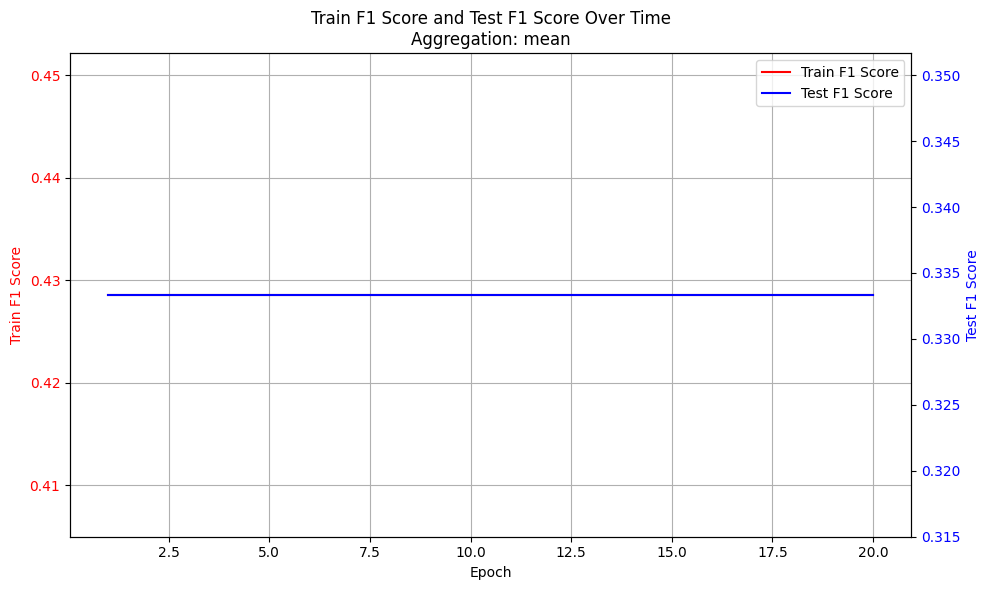

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
Epoch 1, Training Loss: 0.408041820367516, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5167, Train F1-Score: 0.4444, Validation F1-Score: 0.3693
Epoch 2, Training Loss: 0.37585474846348393, Train Accuracy: 0.75, Validation Accuracy: 0.5167, Train F1-Score: 0.4286, Validation F1-Score: 0.3693
Epoch 3, Training Loss: 0.3638235419692302, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 4, Training Loss: 0.35606241452677007, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 5, Training Loss: 0.3508228321531505, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 6, Training Loss: 0.3475621429017999, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 7, Training Loss: 0.3451525

<Figure size 1000x600 with 0 Axes>

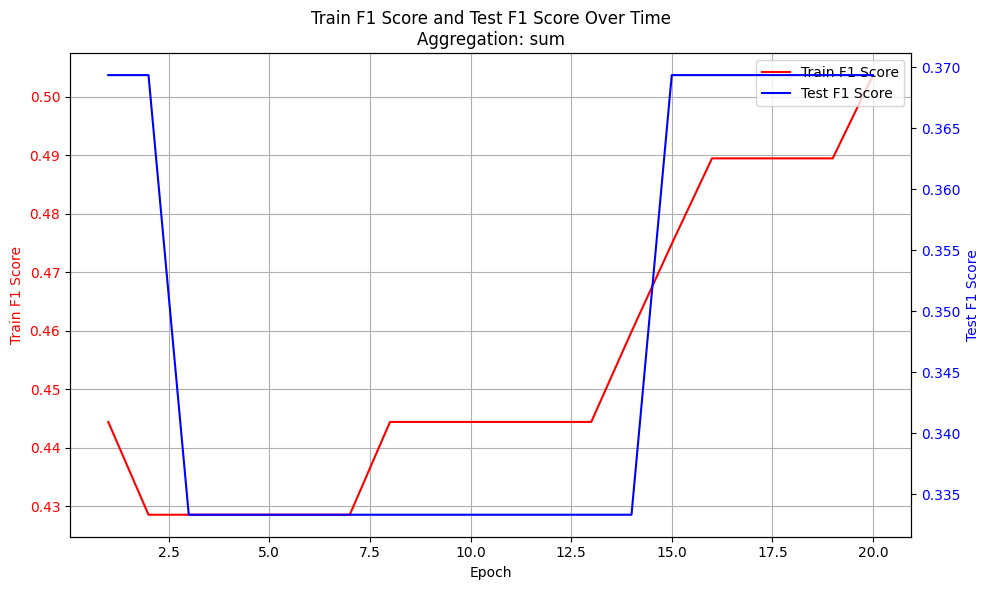

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
Epoch 1, Training Loss: 0.6271214164567717, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 2, Training Loss: 0.5610192734183688, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 3, Training Loss: 0.5369122300974347, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 4, Training Loss: 0.5265051292424853, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 5, Training Loss: 0.5184115382532278, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 6, Training Loss: 0.5108763554105253, Train Accuracy: 0.75, Validation Accuracy: 0.5000, Train F1-Score: 0.4286, Validation F1-Score: 0.3333
Epoch 7, Training Loss: 0.5032151121871941, Trai

<Figure size 1000x600 with 0 Axes>

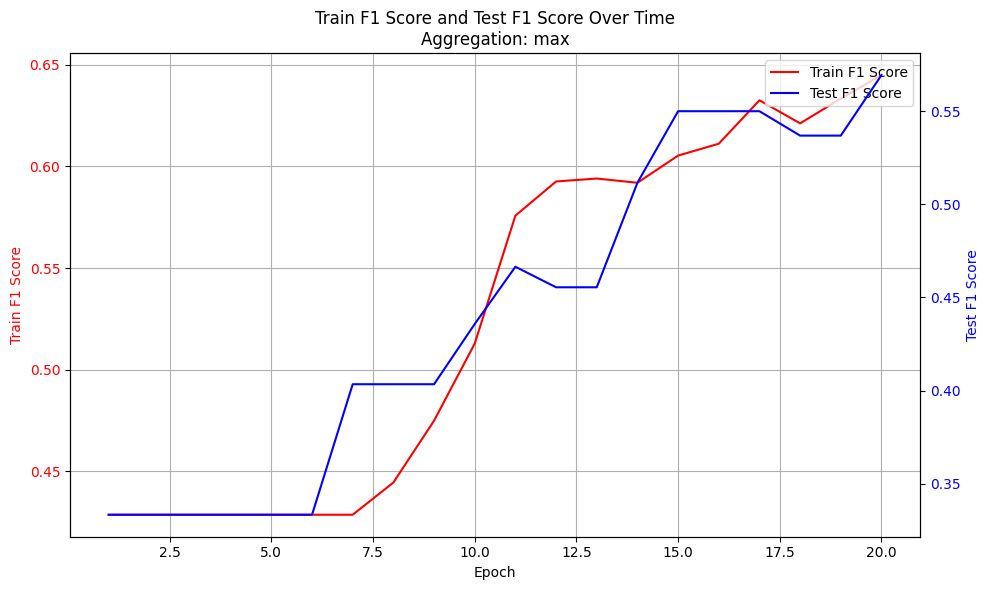

In [240]:
# Run all three aggregation functions here.
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8

aggregation_methods = ["mean", "sum", "max"]
models = []
f1 = []
# TRAIN
for aggregation_method in aggregation_methods:
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    print(model)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    train_losses, train_acc, eval_acc, train_f1_scores, eval_f1_scores = train_model(
        model, 
        optimizer, 
        criterion, 
        train_data, 
        eval_data, 
        epochs=num_epochs, 
        graph_aggregation_method=aggregation_method,
        verbose=True
    )

    models.append(model)

    # Visualising
    plot_training_and_validation(train_f1_scores, eval_f1_scores, aggregation=aggregation_method, graph1_label="Train F1 Score", graph2_label="Test F1 Score", x_label="Epoch")

### Q1.1.c - Training vs. Evaluation F1

Additionally, compare training F1 scores vs. evaluation F1 scores. What differences do you
observe? Which aggregation function performs best and why (sum, mean, or max)?

Aggregation Method: mean
Training F1-Score: 0.4286
Evaluation F1-Score: 0.3333
Aggregation Method: sum
Training F1-Score: 0.5037
Evaluation F1-Score: 0.3693
Aggregation Method: max
Training F1-Score: 0.6449
Evaluation F1-Score: 0.5694


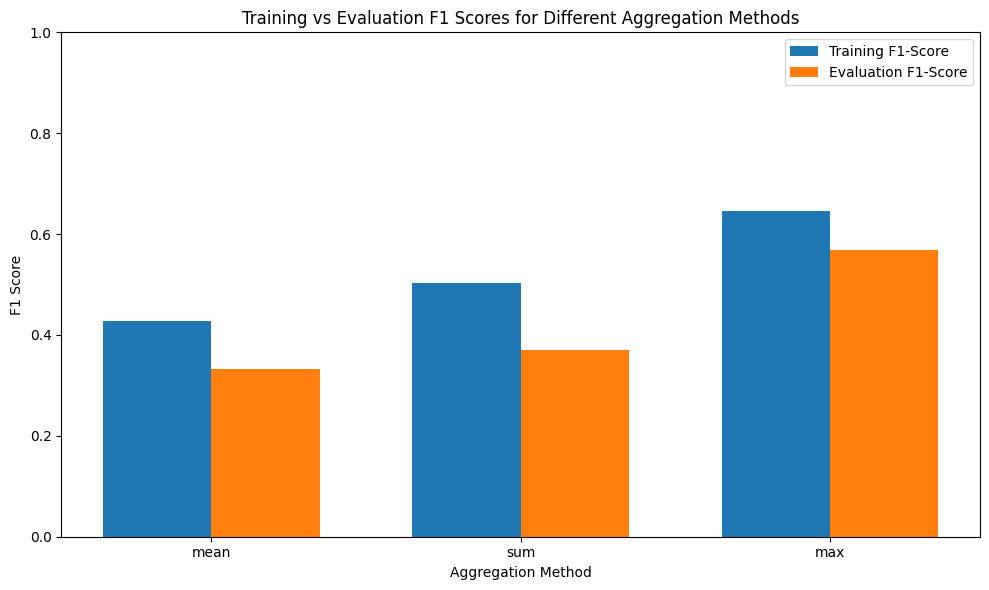

In [241]:
# Solution Q1.1.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

train_f1_scores = []
eval_f1_scores = []

for aggregation_method, model in zip(aggregation_methods, models):
    # Calculate F1 score for training data
    true_labels_train, predicted_labels_train, _ = test(model, train_data)
    train_f1_score_value = f1_score(true_labels_train, predicted_labels_train, average='macro')
    train_f1_scores.append(train_f1_score_value)
    
    # Calculate F1 score for evaluation data
    true_labels_eval, predicted_labels_eval, _ = test(model, eval_data)
    eval_f1_score_value = f1_score(true_labels_eval, predicted_labels_eval, average='macro')
    eval_f1_scores.append(eval_f1_score_value)

    print(f"Aggregation Method: {aggregation_method}")
    print(f"Training F1-Score: {train_f1_score_value:.4f}")
    print(f"Evaluation F1-Score: {eval_f1_score_value:.4f}")

# Plotting F1 scores for training and evaluation
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(aggregation_methods))

bar1 = plt.bar(index, train_f1_scores, bar_width, label='Training F1-Score')
bar2 = plt.bar(index + bar_width, eval_f1_scores, bar_width, label='Evaluation F1-Score')

plt.xlabel('Aggregation Method')
plt.ylabel('F1 Score')
plt.title('Training vs Evaluation F1 Scores for Different Aggregation Methods')
plt.xticks(index + bar_width / 2, aggregation_methods)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

# ####################################################
# END OF MODIFICATION
# ####################################################  


## Q1.2 - Analyzing the Dataset

You may notice that the model performs worse on the evaluation dataset. The goal of this task
is to analyze the dataset and identify potential issues that might affect the model’s performance.


In [242]:
# Helper function to visualise graphs:
def visualize_graph(G):
    """Visualize the generated graph."""
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True,
        node_size=500, font_size=8, font_color="white", edge_color="gray"
    )
    plt.title("Homogenous Graph Visualization")
    plt.show()

def visualise_graph_features(features_0, features_1):
    """plot clusters and their distribution"""
    plt.figure(figsize=(12, 8))
    
    # Convert to numpy arrays and get the first feature dimension
    features_0_np_1 = np.array(features_0)[:, 0]  # Take first feature dimension
    features_0_np_2 = np.array(features_0)[:, 1]  # Take second feature dimension
    
    features_1_np_1 = np.array(features_1)[:, 0]  # Take first feature dimension
    features_1_np_2 = np.array(features_1)[:, 1]  # Take first feature dimension
   
    plt.scatter(features_0_np_1, features_0_np_2, alpha=0.6, label='Class 0', color='red')
    plt.scatter(features_1_np_1, features_1_np_2, alpha=0.6, label='Class 1', color='blue')

    plt.xlabel('First Feature Dimension')
    plt.ylabel('Second Feature Dimension') 
    plt.title('Feature Distribution by Class')
    plt.legend()
    plt.show()

### Q1.2.a - Plotting
• Plot the topologies of the graphs.

• Plot the feature distributions.

• Plot the label distributions.

In [243]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
def plot_class_distribution(labels):
    """Plots the distribution of labels"""
    plt.figure(figsize=(8, 6))
    classes, counts = np.unique(labels, return_counts=True)
    plt.bar(classes, counts, color=['red', 'blue'])
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()


def plot_graph_topology(A):
    """Plots the graph topology"""
    G = nx.from_numpy_array(A.numpy())
    visualize_graph(G)

# ####################################################
# END OF MODIFICATION
# #################################################### 

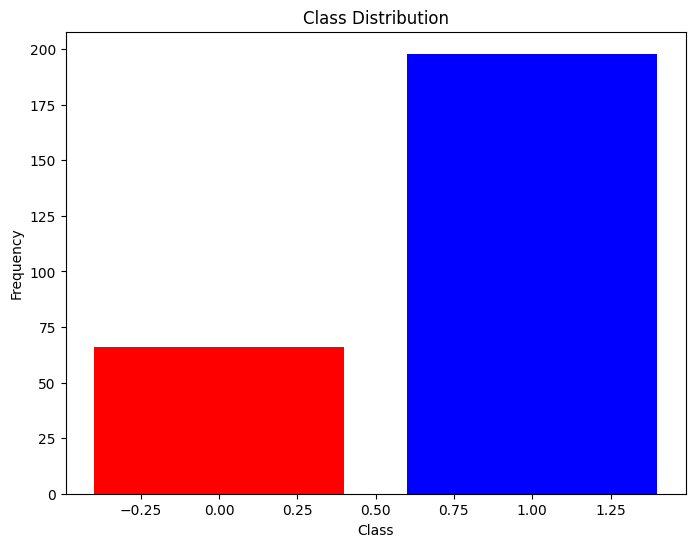

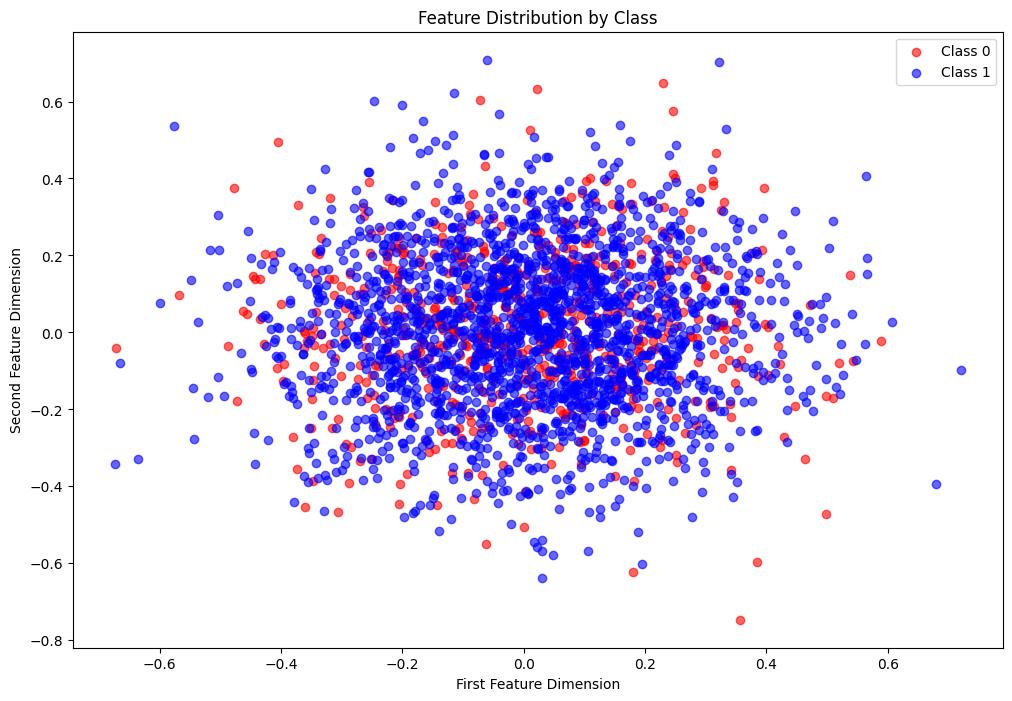

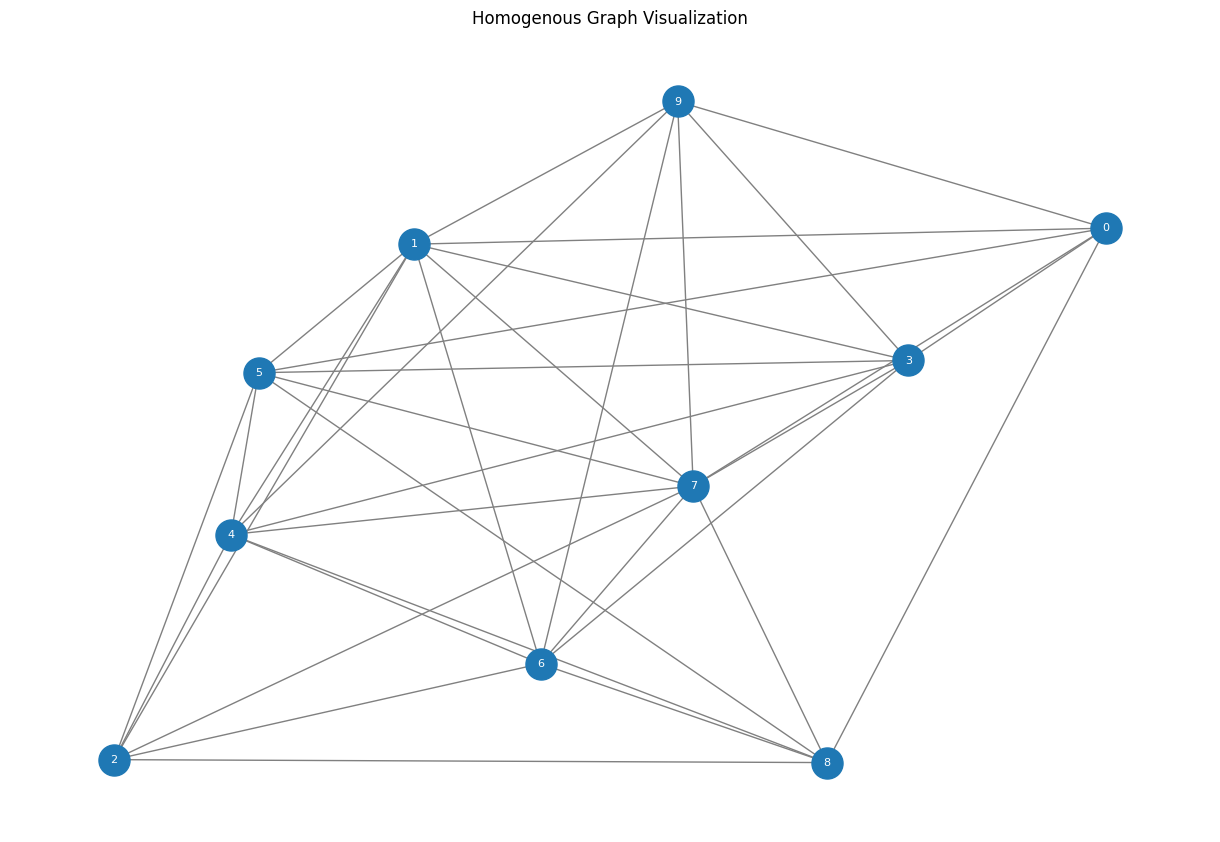

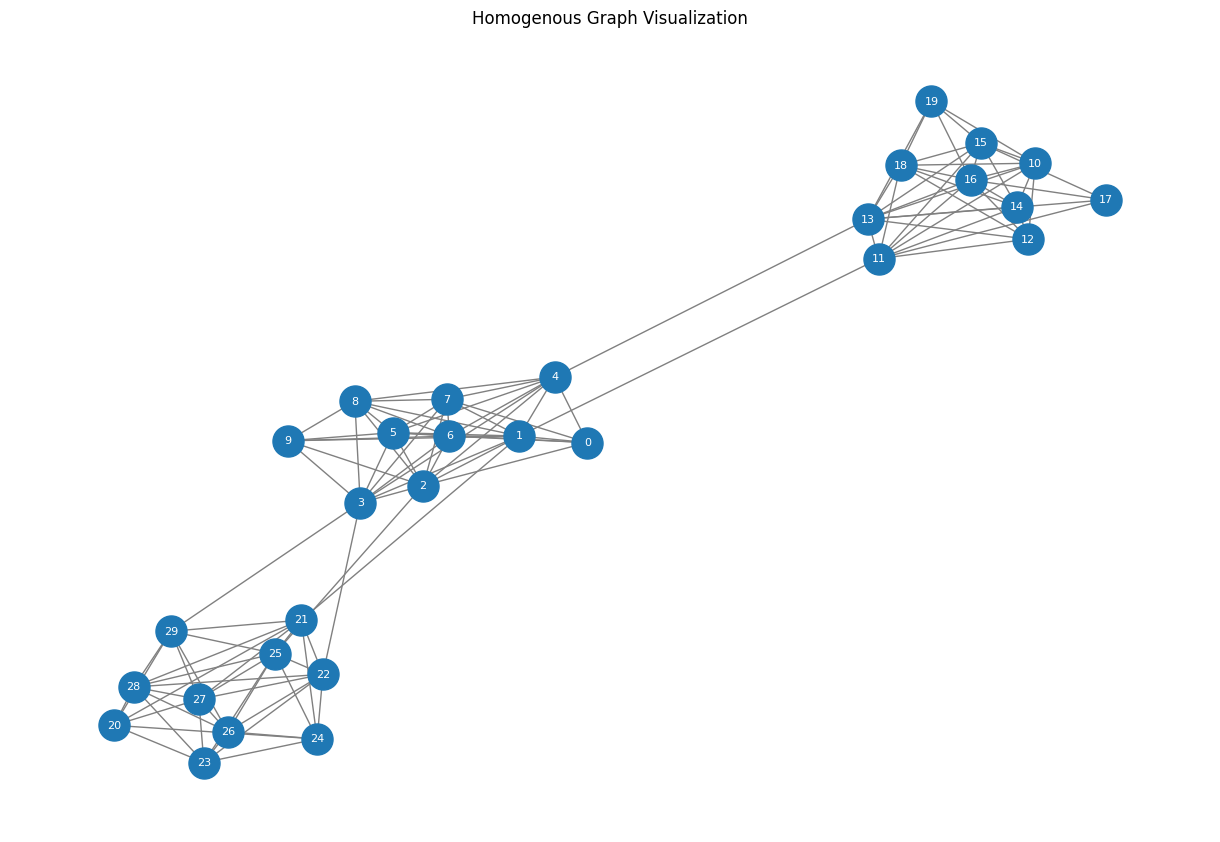

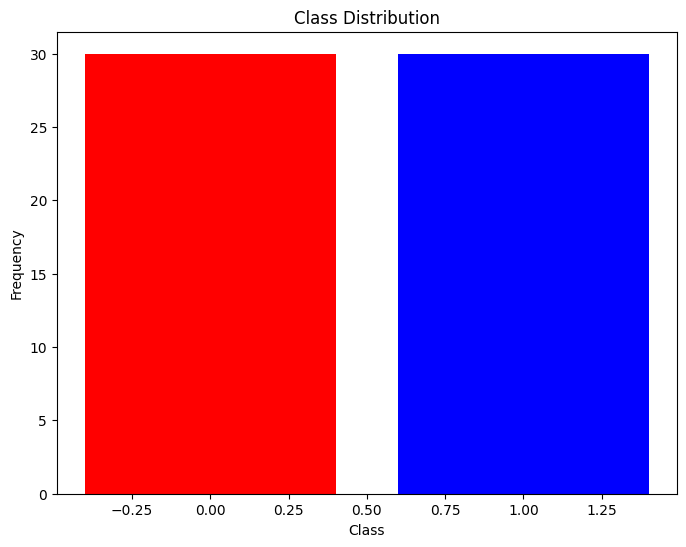

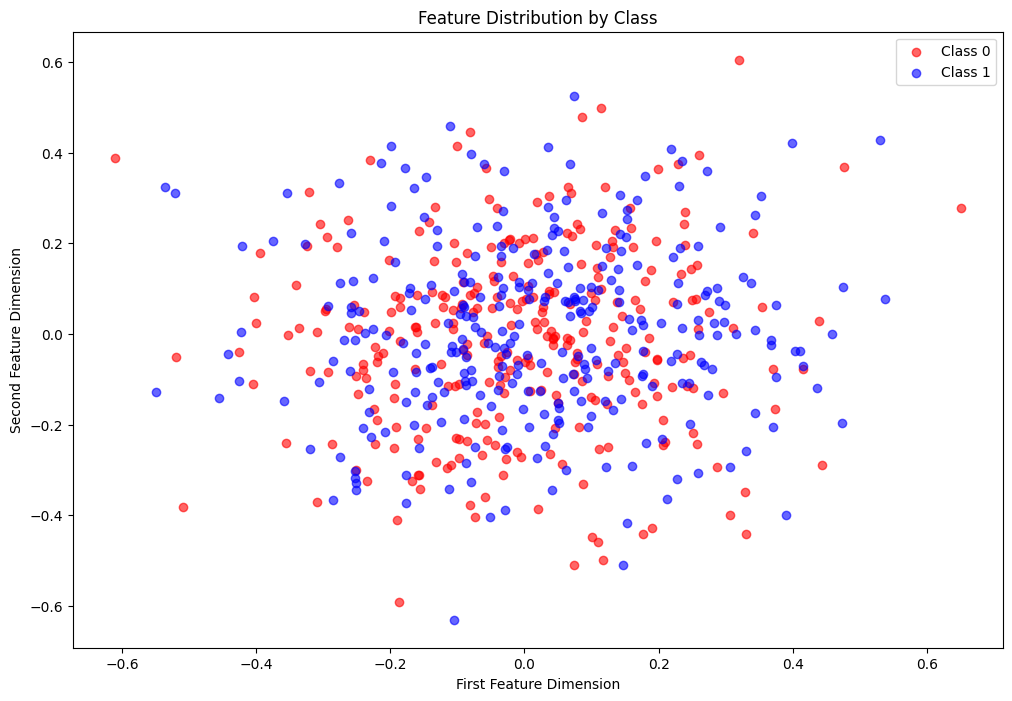

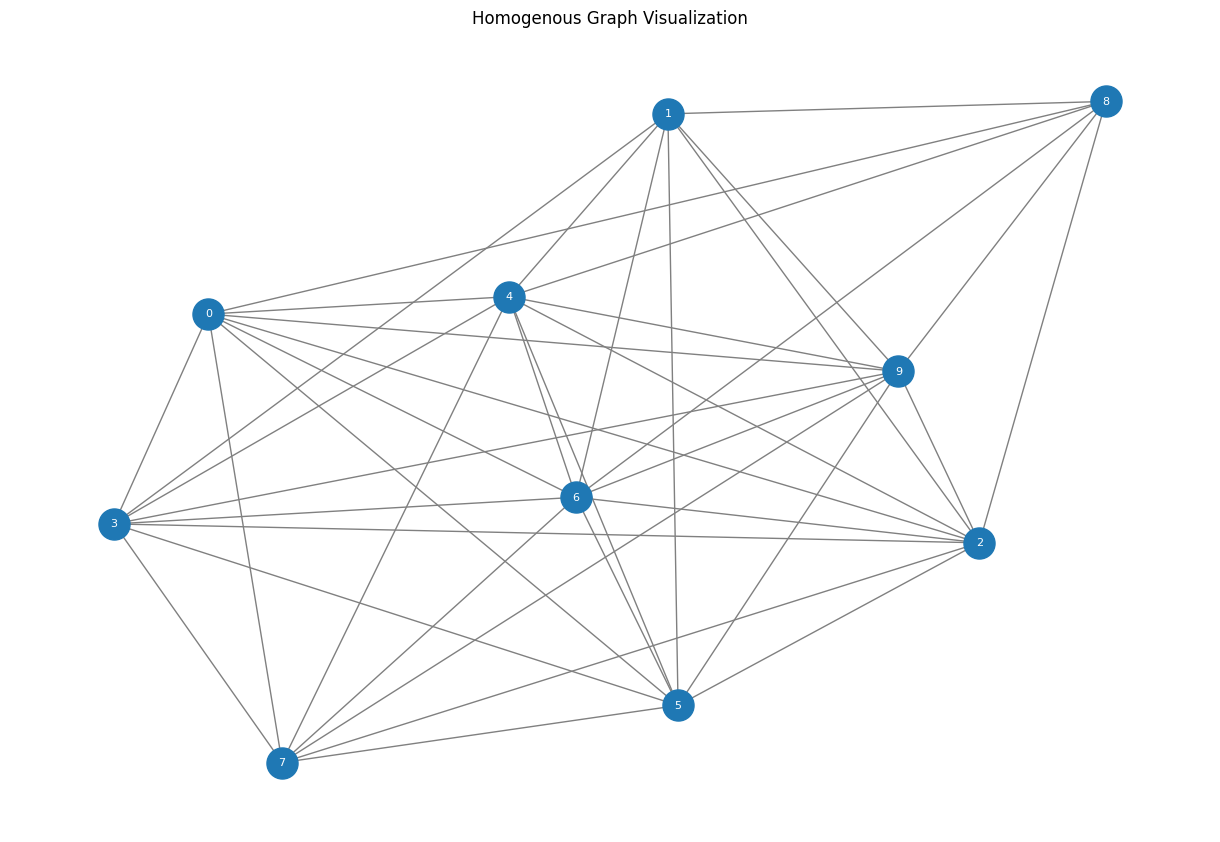

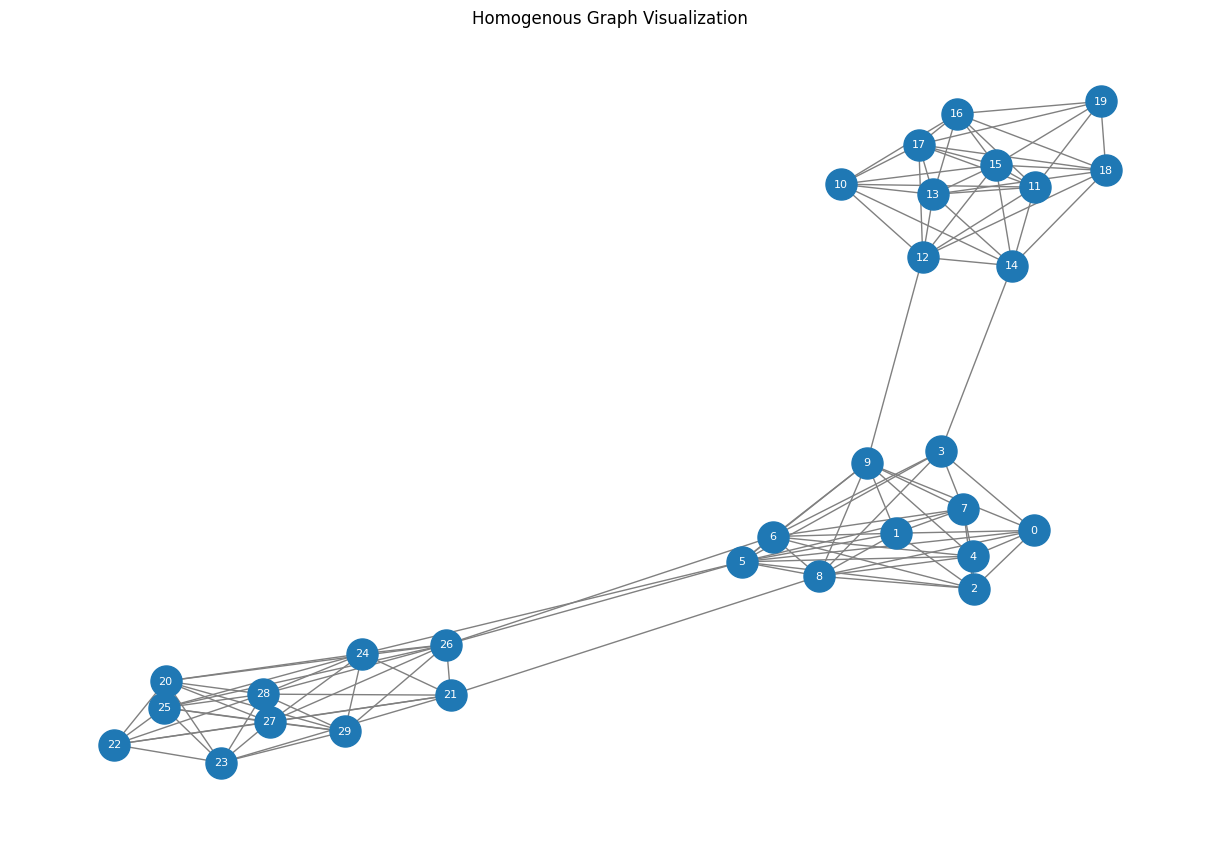

In [244]:
# Run the above scripts for train and eval. What do you observe?
def find_X_A_for_label(list_of_data,label=1):
    """Label"""
    for X,A,y in list_of_data:
        if y==label:
            return X,A

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Getting Labels
train_labels = [int(y) for _,_,y in train_data]
eval_labels = [int(y) for _,_,y in eval_data]

# Getting Features
train_features_0 = [X.numpy() for X, _, y in train_data if y == 0]
train_features_1 = [X.numpy() for X, _, y in train_data if y == 1]

eval_features_0 = [X.numpy() for X, _, y in eval_data if y == 0]
eval_features_1 = [X.numpy() for X, _, y in eval_data if y == 1]

# Find a graph for each of the classes
X0_train, A0_train = find_X_A_for_label(train_data, 0)
X1_train, A1_train = find_X_A_for_label(train_data, 1)

X0_eval,A0_eval = find_X_A_for_label(eval_data, 0)
X1_eval, A1_eval = find_X_A_for_label(eval_data, 1)

# Plotting Train
plot_class_distribution(train_labels)
visualise_graph_features(train_features_0, train_features_1)
plot_graph_topology(A0_train)
plot_graph_topology(A1_train)

# Plotting Eval
plot_class_distribution(eval_labels)
visualise_graph_features(eval_features_0, eval_features_1)
plot_graph_topology(A0_eval)
plot_graph_topology(A1_eval)





## Question 1.3 - Overcoming Dataset Challenges

In this section, you will attempt to address the challenges identified by improving the model or training process.

### Q1.3.a - Adapting the GCN

Modify your GCN implementation from Q1.1 to accept the number of layers and output dimen-
sion (i.e. the graph embedding dimension) as parametes. Experiment with different hyperparam-
eters, such as:

• Number of layers.

• Hidden dimension size.

You will implement:

• Implement GCN as described above.

• Experiment with hyperparameters and report the results and plots.

Hint: The ModuleList class might be useful.

In [ ]:
# SOLUTION Q1.3.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer2(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer2, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork2(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=1):
        super(MyGraphNeuralNetwork2, self).__init__()
        self.num_layers = [num_layers]
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(MyGCNLayer2(input_dim, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(MyGCNLayer2(hidden_dim, hidden_dim))
        
        # Final layer
        self.layers.append(MyGCNLayer2(hidden_dim, output_dim, use_nonlinearity=False))

        self.classification_head = nn.Linear(output_dim, 1)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Pass through GCN layers
        A_tilde = A + torch.eye(A.shape[0])  # Add self loops
        A_normalized = symmetric_normalize(A_tilde)

        # Forward pass through each layer
        graph_embedding = []
        H = X
        for layer in self.layers:
            H = layer(H, A_normalized)
            graph_embedding.append(H)

        # Graph aggregation
        if graph_aggregation_method == 'sum':
            graph_output = H.sum(dim=0)
        elif graph_aggregation_method == 'max':
            graph_output = H.max(dim=0).values
        else: # Default to mean
            graph_output = H.mean(dim=0)

        graph_output = self.classification_head(graph_output)

        # Sigmoid activation
        graph_output = torch.sigmoid(graph_output.squeeze())

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_graph_embedding", None):
            return graph_output, graph_embedding
        else:
            return graph_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

In [254]:
import seaborn as sns
import pandas as pd
# Run different hyper params here

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
output_dim = 8

# Define hyperparameters to experiment with
hidden_dims = [8, 16, 32, 64, 128, 256, 512]
num_layers_list = [2, 3, 4, 5]

# Store results for each combination
results = []

for hidden_dim in hidden_dims:
    for num_layers in num_layers_list:
        print(f"Training with hidden_dim={hidden_dim}, num_layers={num_layers}")

        model = MyGraphNeuralNetwork2(input_dim, hidden_dim, num_layers, output_dim)

        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # TRAIN
        num_epochs = 20
        train_losses, train_acc, eval_acc, train_f1_scores, eval_f1_scores = train_model(
            model, 
            optimizer, 
            criterion, 
            train_data, 
            eval_data,
            epochs=num_epochs, 
            graph_aggregation_method="mean",
            verbose=False
        )

        # Store the results
        result = {
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'train_f1_score': train_f1_scores[-1],
            'eval_f1_score': eval_f1_scores[-1]
        }

        print(result)
        results.append(result)

Training with hidden_dim=8, num_layers=2
{'hidden_dim': 8, 'num_layers': 2, 'train_f1_score': 0.5310552461237392, 'eval_f1_score': 0.3693367162015223}
Training with hidden_dim=8, num_layers=3
{'hidden_dim': 8, 'num_layers': 3, 'train_f1_score': 0.5310552461237392, 'eval_f1_score': 0.3693367162015223}
Training with hidden_dim=8, num_layers=4
{'hidden_dim': 8, 'num_layers': 4, 'train_f1_score': 0.42857142857142855, 'eval_f1_score': 0.3333333333333333}
Training with hidden_dim=8, num_layers=5
{'hidden_dim': 8, 'num_layers': 5, 'train_f1_score': 0.7152662025688793, 'eval_f1_score': 0.45546218487394957}
Training with hidden_dim=16, num_layers=2
{'hidden_dim': 16, 'num_layers': 2, 'train_f1_score': 0.503682929084353, 'eval_f1_score': 0.3693367162015223}
Training with hidden_dim=16, num_layers=3
{'hidden_dim': 16, 'num_layers': 3, 'train_f1_score': 0.676597075611854, 'eval_f1_score': 0.48412698412698413}
Training with hidden_dim=16, num_layers=4
{'hidden_dim': 16, 'num_layers': 4, 'train_f1_s

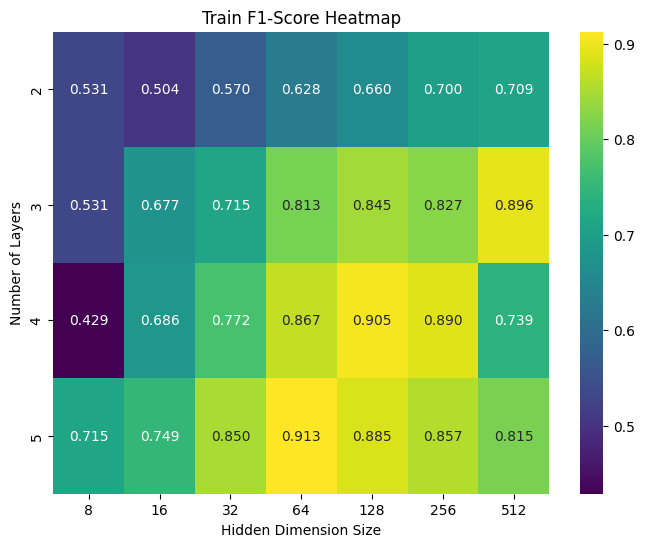

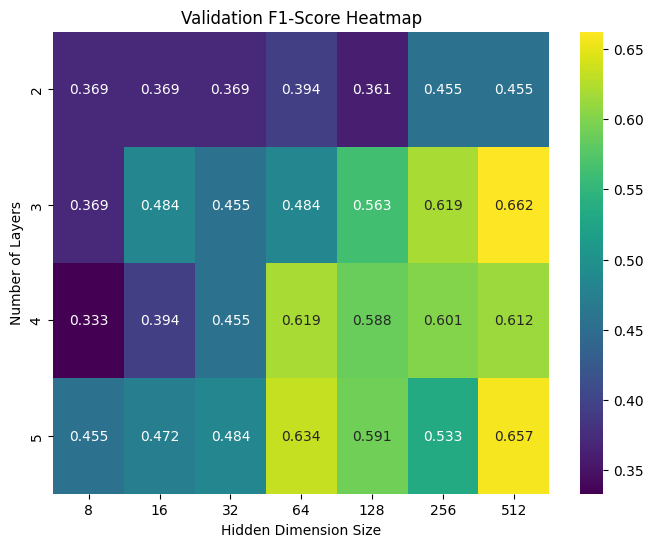

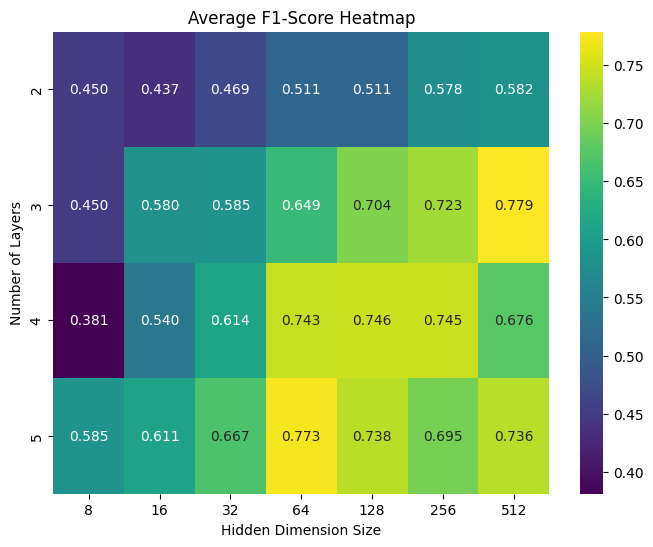

In [256]:
# Convert results into a DataFrame
df = pd.DataFrame(results)

# Plot Train F1-Scores
heatmap_data = df.pivot(index="num_layers", columns="hidden_dim", values="train_f1_score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")

plt.xlabel("Hidden Dimension Size")
plt.ylabel("Number of Layers")
plt.title("Train F1-Score Heatmap")

plt.show()

# Plot Validation F1-Scores
heatmap_data = df.pivot(index="num_layers", columns="hidden_dim", values="eval_f1_score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")

plt.xlabel("Hidden Dimension Size")
plt.ylabel("Number of Layers")
plt.title("Validation F1-Score Heatmap")

plt.show()

# Plot Train + Validation F1-Scores

def avg_f1_score(row):
    row['avg_f1_score'] = (row['train_f1_score'] + row['eval_f1_score']) / 2
    return row

results_avg = map(avg_f1_score, results)

heatmap_data = pd.DataFrame(results_avg).pivot(index="num_layers", columns="hidden_dim", values="avg_f1_score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")
plt.xlabel("Hidden Dimension Size")
plt.ylabel("Number of Layers")
plt.title("Average F1-Score Heatmap")

plt.show()


### Q1.3.b - Improving the Model
Identify and implement three different methods to overcome the challenges discovered in
Q1.2. Your goal is to achieve the highest possible score. You may experiment with:

• Model architecture modifications.

• Data preprocessing techniques.

• Hyperparameter tuning.

• Loss function adjustments.

In [265]:
# SOLUTION Q1.3.b

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

# New Model
class MyGCNLayer3(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer3, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork3(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=1):
        super(MyGraphNeuralNetwork3, self).__init__()
        self.num_layers = [num_layers]
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(MyGCNLayer3(input_dim, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(MyGCNLayer3(hidden_dim, hidden_dim))
        
        # Final layer
        self.layers.append(MyGCNLayer3(hidden_dim, output_dim, use_nonlinearity=False))

        self.classification_head = nn.Linear(output_dim, 1)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Pass through GCN layers
        A_tilde = A + torch.eye(A.shape[0])  # Add self loops
        A_normalized = symmetric_normalize(A_tilde)

        # Forward pass through each layer
        graph_embedding = []
        H = X
        for layer in self.layers:
            H = layer(H, A_normalized)
            graph_embedding.append(H)

        # Graph aggregation
        if graph_aggregation_method == 'sum':
            graph_output = H.sum(dim=0)
        elif graph_aggregation_method == 'max':
            graph_output = H.max(dim=0).values
        else: # Default to mean
            graph_output = H.mean(dim=0)

        graph_output = self.classification_head(graph_output)

        # Sigmoid activation
        graph_output = torch.sigmoid(graph_output)

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_graph_embedding", None):
            return graph_output, graph_embedding
        else:
            return graph_output

# ####################################################
# END OF MODIFICATION
# ####################################################

In [282]:
# Run different hyper params here

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10


# Best Hyperparameters from previous experiment
hidden_dims = 512
num_layers_list = 3

# Hyperparameters to experiment with
aggregation_methods = ["max"]
output_dims = [1, 2, 4, 8, 16, 32]

# Store results for each combination
results = []

train_labels = [int(y) for _,_,y in train_data]
classes, counts = np.unique(train_labels, return_counts=True)

total_samples = len(train_labels)
numOfClasses = len(classes)

class_1_samples = [(X, A, y) for X,A,y in train_data if y == 1]
class_0_samples = [(X, A, y) for X,A,y in train_data if y == 0]

class_1_samples_count = len(class_1_samples)
class_0_samples_count = len(class_0_samples)

# Oversampling
oversampling = False
weighted_loss = True

if oversampling:
    diff = len(class_1_samples) - len(class_0_samples)

    # Randomly duplicate samples from class 1 to balance the dataset
    if diff > 0:
        class_0_samples.extend(random.choices(class_1_samples, k=diff))
    else:
        class_1_samples.extend(random.choices(class_0_samples, k=-diff))

    # Combine the balanced samples
    train_data = class_0_samples + class_1_samples
    random.shuffle(train_data)

# Compute loss_weight
if weighted_loss:
    weight = torch.tensor(class_0_samples_count / class_1_samples_count, dtype=torch.float32)
else:
    weight = None

for aggregation_method in aggregation_methods:
    for output_dim in output_dims:

        print(f"Training with aggregation_method={aggregation_method}, output_dim={output_dim}, oversampling={oversampling}, weighted_loss={weighted_loss}")

        model = MyGraphNeuralNetwork3(input_dim, hidden_dim, num_layers, output_dim)

        # Loss function and optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Use BCELoss with weight to help address imbalance
        criterion = nn.BCELoss(weight=weight)

        # TRAIN
        num_epochs = 20
        train_losses, train_acc, eval_acc, train_f1_scores, eval_f1_scores = train_model(
            model, 
            optimizer, 
            criterion, 
            train_data, 
            eval_data,
            epochs=num_epochs, 
            graph_aggregation_method=aggregation_method,
            verbose=False
        )

        result = {
            'aggregation_method': aggregation_method,
            'output_dim': output_dim,
            'oversampling': oversampling,
            'weighted_loss': weighted_loss,
            'train_f1_score': train_f1_scores[-1],
            'eval_f1_score': eval_f1_scores[-1],
        }

        print(result)

        # Store the results
        results.append(result)


Training with aggregation_method=max, output_dim=1, oversampling=False, weighted_loss=True
{'aggregation_method': 'max', 'output_dim': 1, 'oversampling': False, 'weighted_loss': True, 'train_f1_score': 0.732443455691509, 'eval_f1_score': 0.4357366771159875}
Training with aggregation_method=max, output_dim=2, oversampling=False, weighted_loss=True
{'aggregation_method': 'max', 'output_dim': 2, 'oversampling': False, 'weighted_loss': True, 'train_f1_score': 0.6862004396320118, 'eval_f1_score': 0.5661846496106786}
Training with aggregation_method=max, output_dim=4, oversampling=False, weighted_loss=True
{'aggregation_method': 'max', 'output_dim': 4, 'oversampling': False, 'weighted_loss': True, 'train_f1_score': 0.2, 'eval_f1_score': 0.3333333333333333}
Training with aggregation_method=max, output_dim=8, oversampling=False, weighted_loss=True
{'aggregation_method': 'max', 'output_dim': 8, 'oversampling': False, 'weighted_loss': True, 'train_f1_score': 0.2, 'eval_f1_score': 0.3333333333333

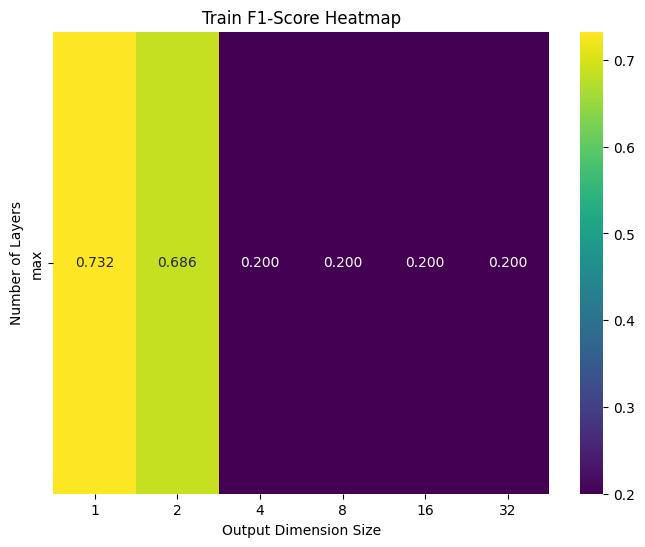

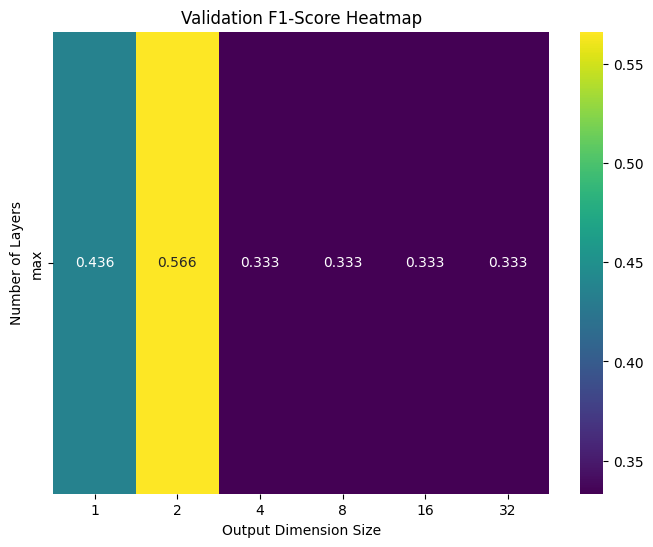

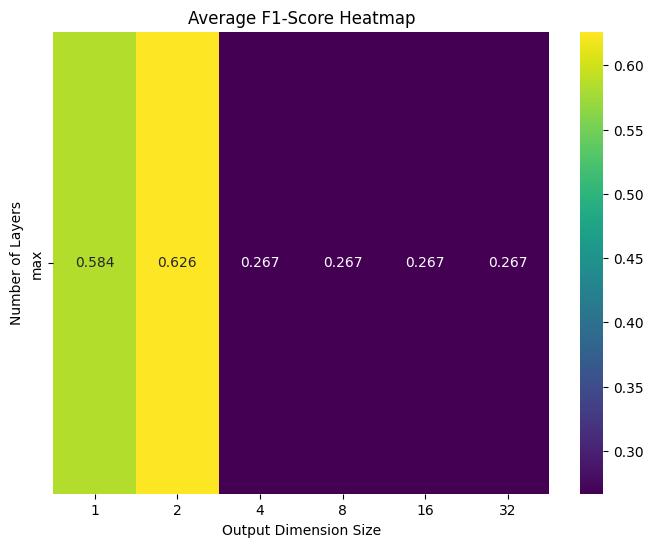

In [283]:
# Convert results into a DataFrame
df = pd.DataFrame(results)

# Plot Train F1-Scores
heatmap_data = df.pivot(index="aggregation_method", columns="output_dim", values="train_f1_score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")

plt.xlabel("Output Dimension Size")
plt.ylabel("Number of Layers")
plt.title("Train F1-Score Heatmap")

plt.show()

# Plot Validation F1-Scores
heatmap_data = df.pivot(index="aggregation_method", columns="output_dim", values="eval_f1_score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")

plt.xlabel("Output Dimension Size")
plt.ylabel("Number of Layers")
plt.title("Validation F1-Score Heatmap")

plt.show()

# Plot Train + Validation F1-Scores

def avg_f1_score(row):
    row['avg_f1_score'] = (row['train_f1_score'] + row['eval_f1_score']) / 2
    return row

results_avg = map(avg_f1_score, results)

heatmap_data = pd.DataFrame(results_avg).pivot(index="aggregation_method", columns="output_dim", values="avg_f1_score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")
plt.xlabel("Output Dimension Size")
plt.ylabel("Number of Layers")
plt.title("Average F1-Score Heatmap")

plt.show()


### Q1.3.c - Evaluating the Best Model

Plot the performance of your best model over 100 epochs or more, averaged over multiple
random (i.i.d.) runs (at least 10 runs) to produce a smoothed training and evaluation accuracy
curve. 

Note: Your score will be based on the smoothed curve.

Hints:

• Set verbose=False in the train model function to suppress excessive logging.

• Use np.mean with an axis parameter to compute the average performance over multiple
runs.


In [251]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


# Call this function in the end (with the averaged values)
plot_training_and_validation(averaged_train_acc, averaged_eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################

NameError: name 'averaged_train_acc' is not defined